In [1]:
from util import *

# Trading Notebook

Running backtests with various parameters in training, then running OOS tests.

In [2]:
# Change to directory of dataset file
# Dataset file is guaranteed to have all days for all stocks, i.e. shift(30) is guaranteed to be 30 calendar days
# This leaves a lot of NaNs to be filled
path = "~/s3local/sentimentgroup/datasets/roberta_sources.parquet"

In [3]:
# Horizons to calculate future returns (e.g. price after N days)
target_horizons = [1, 3, 5, 10, 30]
# Horizons to calculate lookbacks for rolling means (e.g. mean sentiment over last N days)
lookback_periods = [5, 10, 30]

# Date range, leave None to use all available data (where we have prices)
start_date = "2014-01-01"
end_date = "2025-01-01" # Keep out of sample for now
df = load_dataset(
    path,
    target_horizons = target_horizons,
    lookback_periods = lookback_periods,
    residualise_returns = False,
    start_date=start_date,
    end_date=end_date,
    sources=True,
)

100%|██████████| 5/5 [00:02<00:00,  1.70it/s]
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_{lookback}"] = np.array(((
/Users/raleghaustin/Documents/uni/group-project/Correlation/util.py:128: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.ins

In [4]:
# Normalised features only
news_fts = [c for c in df.columns if c.startswith('ft_news') and c.split("_")[-1].isdigit()]
submissions_fts = [c for c in df.columns if c.startswith('ft_submissions') and c.split("_")[-1].isdigit()]
comments_fts = [c for c in df.columns if c.startswith('ft_comments') and c.split("_")[-1].isdigit()]

In [5]:
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
import copy
import bisect

In [6]:
def walk_forward_predict(df, m, fts, tgt, start_date, end_date, tgt_lookhead_offset=10):
    # Create a copy and ensure datetime types
    # df = df.copy()
    # df['dt'] = pd.to_datetime(df['dt'])
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Sort by date
    df.sort_values('dt', inplace=True) #.reset_index(drop=True)
    
    # Add prediction column
    df['prediction'] = np.nan
    
    # Create a list of unique dates and their first indices
    dates_and_indices = []
    prev_date = None
    for i, date in enumerate(df['dt']):
        if date != prev_date:
            dates_and_indices.append((date, i))
            prev_date = date
    
    # Extract dates and indices into separate lists for binary search
    unique_dates = [d[0] for d in dates_and_indices]
    date_indices = [d[1] for d in dates_and_indices]
    
    # Add an end marker index
    date_indices.append(len(df))
    
    # Find the range of dates to predict
    start_pos = bisect.bisect_left(unique_dates, start_date)
    end_pos = bisect.bisect_right(unique_dates, end_date)
    pred_dates_range = unique_dates[start_pos:end_pos]
    
    if not pred_dates_range:
        return df
    
    # Model caching for performance
    last_train_cutoff = None
    trained_model = None
    
    for pred_date in pred_dates_range:
        print(pred_date)
        # Calculate training cutoff
        train_cutoff = pred_date - pd.Timedelta(days=tgt_lookhead_offset + 1)
        
        # Only retrain if necessary
        if last_train_cutoff != train_cutoff:
            # Find the position in unique_dates for the training cutoff
            train_pos = bisect.bisect_left(unique_dates, train_cutoff)
            
            # If train_pos is 0, we don't have any training data before cutoff
            if train_pos == 0 and unique_dates[0] >= train_cutoff:
                continue
            
            # Get the end index for training data
            if train_pos == 0:
                train_idx = 0
            else:
                train_idx = date_indices[train_pos - 1]
            
            # Get all training data before the cutoff using slice
            X_train = df.iloc[:train_idx][fts].values
            y_train = df.iloc[:train_idx][tgt].values
            
            if len(X_train) == 0:
                continue
                
            # Train the model
            trained_model = copy.deepcopy(m)
            trained_model.fit(X_train, y_train)
            
            # Update cache
            last_train_cutoff = train_cutoff
        
        # Find the position of the prediction date
        pred_pos = bisect.bisect_left(unique_dates, pred_date)
        
        # Get indices for this date
        pred_start_idx = date_indices[pred_pos]
        pred_end_idx = date_indices[pred_pos + 1]
        
        # Get prediction data
        X_pred = df.iloc[pred_start_idx:pred_end_idx][fts].values
        
        # Make and store predictions
        preds = trained_model.predict(X_pred)
        df.iloc[pred_start_idx:pred_end_idx, df.columns.get_loc('prediction')] = preds
    
    return df

In [ ]:
m10 = Ridge(alpha=1)
df = walk_forward_predict(df, m10, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_10', start_date=datetime(2018, 1, 1), end_date=datetime(2025, 1, 1), tgt_lookhead_offset=15)
df['pred_10'] = df.prediction

2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00


In [ ]:
m5 = Ridge(alpha=1)
df = walk_forward_predict(df, m5, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_5', start_date=datetime(2018, 1, 1), end_date=datetime(2025, 1, 1), tgt_lookhead_offset=15)
df['pred_5'] = df.prediction

2018-01-01 00:00:00
2018-01-02 00:00:00
2018-01-03 00:00:00
2018-01-04 00:00:00
2018-01-05 00:00:00
2018-01-06 00:00:00
2018-01-07 00:00:00
2018-01-08 00:00:00
2018-01-09 00:00:00
2018-01-10 00:00:00
2018-01-11 00:00:00
2018-01-12 00:00:00
2018-01-13 00:00:00
2018-01-14 00:00:00
2018-01-15 00:00:00
2018-01-16 00:00:00
2018-01-17 00:00:00
2018-01-18 00:00:00
2018-01-19 00:00:00
2018-01-20 00:00:00
2018-01-21 00:00:00
2018-01-22 00:00:00
2018-01-23 00:00:00
2018-01-24 00:00:00
2018-01-25 00:00:00
2018-01-26 00:00:00
2018-01-27 00:00:00
2018-01-28 00:00:00
2018-01-29 00:00:00
2018-01-30 00:00:00
2018-01-31 00:00:00
2018-02-01 00:00:00
2018-02-02 00:00:00
2018-02-03 00:00:00
2018-02-04 00:00:00
2018-02-05 00:00:00
2018-02-06 00:00:00
2018-02-07 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-02-10 00:00:00
2018-02-11 00:00:00
2018-02-12 00:00:00
2018-02-13 00:00:00
2018-02-14 00:00:00
2018-02-15 00:00:00
2018-02-16 00:00:00
2018-02-17 00:00:00
2018-02-18 00:00:00
2018-02-19 00:00:00


In [ ]:
# Simulate a trading portfolio with capital allocation based on signal values.
# def simulate_portfolio_vectorized(df, initial_capital=10000.0, tc_rate=0.001):
#     # Convert input dataframe to a pivot table format for vectorized operations
#     # This creates a multi-indexed DataFrame with dates as index and symbols as columns
#     pivot_close = df.pivot_table(index='dt', columns='symbol', values='close')
#     pivot_signal = df.pivot_table(index='dt', columns='symbol', values='signal')
    
#     # Fill NaN with 0 for signals (no signal = no allocation)
#     pivot_signal = pivot_signal.fillna(0)
    
#     # Get unique dates and symbols
#     dates = pivot_close.index.unique()
#     symbols = pivot_close.columns.unique()
#     n_dates = len(dates)
#     n_symbols = len(symbols)
    
#     # Initialize arrays to store results
#     portfolio_values = np.zeros(n_dates)
#     cash_values = np.zeros(n_dates)
#     position_values = np.zeros(n_dates)
#     transaction_costs = np.zeros(n_dates)
#     positions_array = np.zeros((n_dates, n_symbols))
#     notional_positions_array = np.zeros((n_dates, n_symbols))
    
#     # Initial cash
#     cash_values[0] = initial_capital
#     portfolio_values[0] = initial_capital
    
#     # Process each date (starting from the second date)
#     for t in range(1, n_dates):
#         prev_date = dates[t-1]
#         curr_date = dates[t]
        
#         # Get prices and signals for current date
#         curr_prices = pivot_close.loc[curr_date].values
#         curr_signals = pivot_signal.loc[curr_date].values
        
#         # Replace NaN prices with previous day's prices or zeros
#         prev_prices = pivot_close.loc[prev_date].values
#         mask_curr_nan = np.isnan(curr_prices)
#         curr_prices[mask_curr_nan] = prev_prices[mask_curr_nan]
#         curr_prices[np.isnan(curr_prices)] = 0
        
#         # Get previous positions
#         prev_positions = positions_array[t-1]
        
#         # Current position values before rebalancing
#         prev_position_values = prev_positions * curr_prices
#         prev_portfolio_value = cash_values[t-1] + np.sum(prev_position_values)
        
#         # Calculate total signal and allocation ratios
#         total_signal = np.sum(curr_signals)
        
#         if total_signal > 0:
#             # Calculate target positions based on signal allocation
#             # allocation_ratios = np.exp(curr_signals) / total_signal
#             allocation_ratios = curr_signals / total_signal
#             target_values = prev_portfolio_value * allocation_ratios
#             target_positions = np.zeros_like(target_values)
            
#             # Avoid division by zero
#             mask_valid_prices = curr_prices > 0
#             target_positions[mask_valid_prices] = target_values[mask_valid_prices] / curr_prices[mask_valid_prices]
            
#             # Calculate trades
#             trades = target_positions - prev_positions
#             trade_values = np.abs(trades) * curr_prices
            
#             # Calculate transaction costs
#             trade_costs = trade_values * tc_rate
#             total_cost = np.sum(trade_costs)
            
#             # Process buys (positive trades)
#             buy_mask = trades > 0
#             buy_values = trade_values[buy_mask]
#             buy_costs = trade_costs[buy_mask]
#             total_buy_cost = np.sum(buy_values) + np.sum(buy_costs)
            
#             # Check if we have enough cash
#             if total_buy_cost <= cash_values[t-1]:
#                 # Execute all trades
#                 new_positions = target_positions
#                 new_cash = cash_values[t-1] - np.sum(buy_values) - np.sum(buy_costs)
                
#                 # Add proceeds from sells
#                 sell_mask = trades < 0
#                 sell_values = trade_values[sell_mask]
#                 sell_costs = trade_costs[sell_mask]
#                 new_cash += np.sum(sell_values) - np.sum(sell_costs)
#             else:
#                 # Not enough cash, scale down buys
#                 # This is a simplification; in reality, you might want to prioritize trades
#                 scale_factor = cash_values[t-1] / total_buy_cost if total_buy_cost > 0 else 0
#                 scaled_buys = trades.copy()
#                 scaled_buys[buy_mask] *= scale_factor
                
#                 # Execute scaled trades
#                 new_positions = prev_positions + scaled_buys
                
#                 # Calculate actual costs after scaling
#                 actual_buy_values = np.abs(scaled_buys[buy_mask]) * curr_prices[buy_mask]
#                 actual_buy_costs = actual_buy_values * tc_rate
                
#                 new_cash = cash_values[t-1] - np.sum(actual_buy_values) - np.sum(actual_buy_costs)
                
#                 # Process sells normally
#                 sell_mask = trades < 0
#                 sell_values = trade_values[sell_mask]
#                 sell_costs = trade_costs[sell_mask]
#                 new_cash += np.sum(sell_values) - np.sum(sell_costs)
                
#                 # Recalculate transaction costs
#                 total_cost = np.sum(actual_buy_costs) + np.sum(sell_costs)
#         else:
#             # No signals, sell all positions
#             # Calculate sell values and costs for liquidating all positions
#             sell_values = prev_positions * curr_prices
#             sell_costs = sell_values * tc_rate
            
#             # Update cash with proceeds from sells
#             new_cash = cash_values[t-1] + np.sum(sell_values) - np.sum(sell_costs)
            
#             # Set new positions to zero (liquidate everything)
#             new_positions = np.zeros_like(prev_positions)
            
#             # Total transaction cost is the sum of sell costs
#             total_cost = np.sum(sell_costs)
        
#         # Update state
#         positions_array[t] = new_positions
#         notional_positions_array[t] = new_positions * curr_prices
#         cash_values[t] = new_cash
#         position_values[t] = np.sum(new_positions * curr_prices)
#         portfolio_values[t] = cash_values[t] + position_values[t]
#         transaction_costs[t] = total_cost
    
#     # Create results DataFrame
#     portfolio_df = pd.DataFrame({
#         'date': dates,
#         'portfolio_value': portfolio_values,
#         'cash': cash_values,
#         'positions_value': position_values,
#         'transactions_cost': transaction_costs
#     })
    
#     # Add returns calculations
#     portfolio_df['daily_return'] = (portfolio_df['portfolio_value'] / 
#                                    portfolio_df['portfolio_value'].shift(1) - 1)
#     portfolio_df['cumulative_return'] = (1 + portfolio_df['daily_return']).cumprod() - 1
    
#     # Set date as index
#     portfolio_df = portfolio_df.set_index('date')
    
#     # Create positions DataFrame if needed
#     positions_df = pd.DataFrame(positions_array, index=dates, columns=symbols)
#     notional_positions_df = pd.DataFrame(notional_positions_array, index=dates, columns=symbols)
    
#     return portfolio_df, positions_df, notional_positions_df

,forecast,threshold,cagr,sharpe,drawdown
0,baseline,n/a,17.99%,0.722433,-37.49%
1,pred_5,0.0,16.22%,0.673932,-37.28%
2,pred_5,0.01,20.25%,0.750875,-34.50%
3,pred_5,0.02,10.51%,0.568359,-23.84%
4,pred_5,0.03,7.12%,0.488544,-10.97%
5,pred_5,0.04,6.54%,0.642537,-7.86%
6,pred_10,0.0,16.78%,0.690681,-37.56%
7,pred_10,0.01,34.44%,1.211999,-30.58%
8,pred_10,0.02,35.36%,1.145715,-20.47%
9,pred_10,0.03,5.60%,0.305640,-33.59%


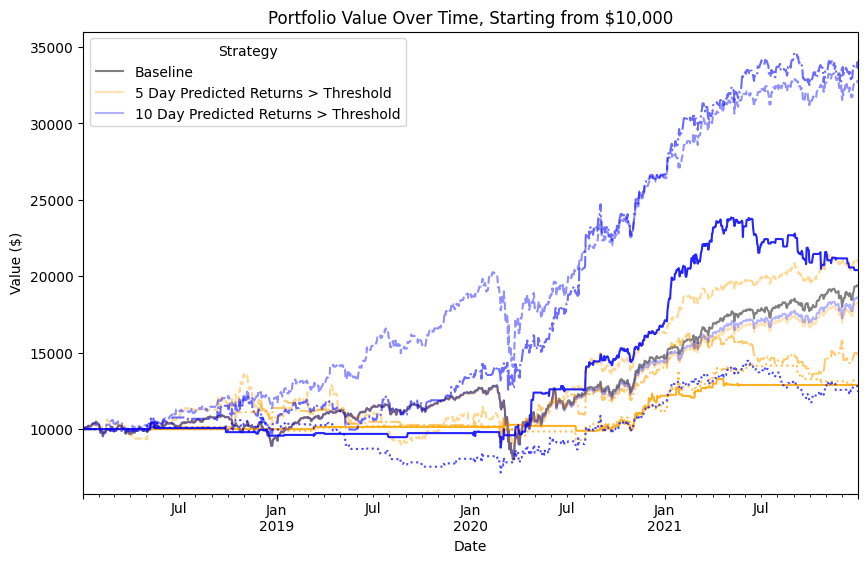

In [ ]:
# In sample tests
t = df[(df.dt > datetime(2018, 1, 1)) & (df.dt < datetime(2022, 1, 1))].copy()
rows = []

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for forecasts
forecast_colors = {
    'baseline': 'grey',
    'pred_5': 'orange',
    'pred_10': 'blue',
}

names = {
    'pred_5': '5 Day Predicted Returns',
    'pred_10': '10 Day Predicted Returns',
}


# Line styles for thresholds
linestyles = ['-', '--', '-.', ':']

# Baseline
t['signal'] = 1.0
port, pos, npos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
port.reset_index().plot(x='date', y='portfolio_value', ax=ax, color='grey', label='Baseline')
total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
cagr = total_returns ** (1/years) - 1
sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
rows.append(["baseline", "n/a",
    f"{100*cagr:.2f}%",
    sharpe,
    f"{100*drawdowns.min():.2f}%",
])

# Forecasts with thresholds
for forecast in ['pred_5', 'pred_10']:
    color = forecast_colors[forecast]
    for i, threshold in enumerate(np.arange(0, 0.05, 0.01)):
        t['signal'] = (t[forecast] > threshold).astype(float)
        port, pos, npos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
        port.reset_index().plot(
            x='date', y='portfolio_value', ax=ax,
            color=color,
            alpha=0.3 + 0.7 * (threshold / 0.05),  # increasing opacity
            linestyle=linestyles[i % len(linestyles)],
            label=f'{names[forecast]} > Threshold'
        )
        total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
        years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
        cagr = total_returns ** (1/years) - 1
        sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
        drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
        rows.append([
            forecast, threshold, 
            f"{100*cagr:.2f}%",
            sharpe,
            f"{100*drawdowns.min():.2f}%",
        ])

# Finalize plot
handles, labels = ax.get_legend_handles_labels()
# Keep only one label per forecast + baseline
seen = set()
filtered = [(h, l) for h, l in zip(handles, labels) if (key := l.split()[0]) not in seen and not seen.add(key)]
ax.legend(*zip(*filtered), title="Strategy")

ax.set_title("Portfolio Value Over Time, Starting from $10,000")
ax.set_ylabel("Value ($)")
ax.set_xlabel("Date")

# Output results DataFrame
results = pd.DataFrame(rows, columns=["forecast", "threshold", "cagr", "sharpe", "drawdown"])
results

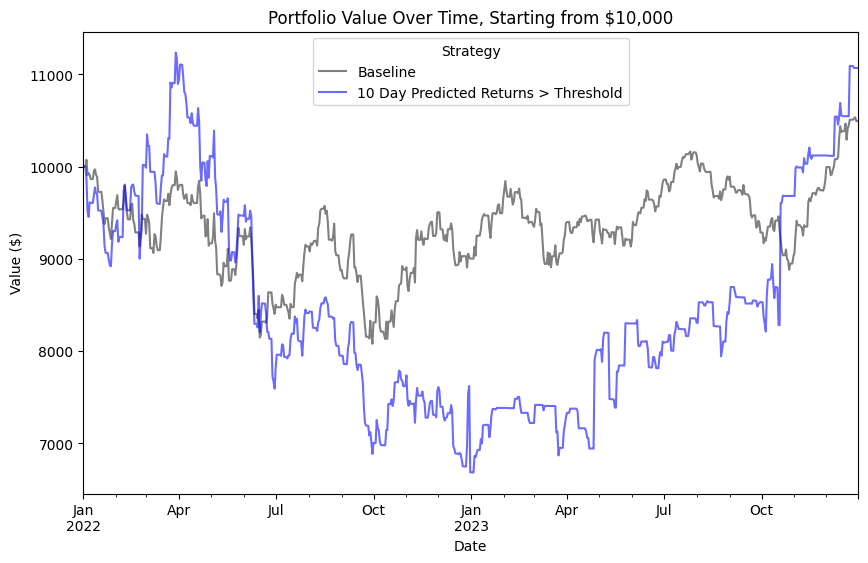

In [ ]:
# Unseen data test
t = df[(df.dt >= datetime(2022, 1, 1)) & (df.dt < datetime(2024, 1, 1))].copy()

# 
rows = []

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Color mapping for forecasts
forecast_colors = {
    'baseline': 'grey',
    'pred_10': 'blue',
}

names = {
    'pred_10': '10 Day Predicted Returns',
}


# Line styles for thresholds
linestyles = ['-', '--', '-.', ':']

# Baseline
t['signal'] = 1.0
port, pos, npos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
port.reset_index().plot(x='date', y='portfolio_value', ax=ax, color='grey', label='Baseline')
total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
cagr = total_returns ** (1/years) - 1
sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
rows.append(["baseline", "n/a",
    f"{100*cagr:.2f}%",
    sharpe,
    f"{100*drawdowns.min():.2f}%",
    f"{-cagr/drawdowns.min():.2f}",
])


# Forecasts with thresholds
for forecast in ['pred_10']:
    color = forecast_colors[forecast]
    for i, threshold in enumerate([0.02]):
        t['signal'] = (t[forecast] > threshold).astype(float)
        port, pos, npos = simulate_portfolio_vectorized(t, tc_rate=0.0002)
        port.reset_index().plot(
            x='date', y='portfolio_value', ax=ax,
            color=color,
            alpha=0.3 + 0.7 * (threshold / 0.05),  # increasing opacity
            linestyle=linestyles[i % len(linestyles)],
            label=f'{names[forecast]} > Threshold'
        )
        total_returns = port.portfolio_value.iloc[-1] / port.portfolio_value.iloc[0]
        years = (port.index[-1] - port.index[0]) / pd.Timedelta(days=365)
        cagr = total_returns ** (1/years) - 1
        sharpe = port.daily_return.mean() / port.daily_return.std() * np.sqrt(252)
        drawdowns = port.portfolio_value / port.portfolio_value.cummax() - 1.0
        rows.append([
            forecast, threshold, 
            f"{100*cagr:.2f}%",
            sharpe,
            f"{100*drawdowns.min():.2f}%",
            f"{-cagr/drawdowns.min():.2f}",
        ])

# Finalize plot
handles, labels = ax.get_legend_handles_labels()
# Keep only one label per forecast + baseline
seen = set()
filtered = [(h, l) for h, l in zip(handles, labels) if (key := l.split()[0]) not in seen and not seen.add(key)]
ax.legend(*zip(*filtered), title="Strategy")

ax.set_title("Portfolio Value Over Time, Starting from $10,000")
ax.set_ylabel("Value ($)")
ax.set_xlabel("Date")

# Output results DataFrame
results = pd.DataFrame(rows, columns=["forecast", "threshold", "cagr", "sharpe", "drawdown", "cagr/drawdown"])

In [ ]:
results

,forecast,threshold,cagr,sharpe,drawdown,cagr/drawdown
0,baseline,n/a,2.43%,0.183957,-19.80%,0.12
1,pred_10,0.02,9.27%,0.367605,-37.39%,0.25


## Feature Importance

In [ ]:
# Train a model at the end of our dataset
m10_final = Ridge(alpha=1)
df = walk_forward_predict(df, m10_final, news_fts + submissions_fts + comments_fts, 'tgt_forward_returns_10', start_date=datetime(2023, 12, 31), end_date=datetime(2024, 1, 1), tgt_lookhead_offset=15)

2023-12-25 00:00:00
2023-12-26 00:00:00
2023-12-27 00:00:00
2023-12-28 00:00:00
2023-12-29 00:00:00
2023-12-30 00:00:00
2023-12-31 00:00:00
2024-01-01 00:00:00


In [ ]:
# Analysing contributed error improvement from each group of sources
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
reduced_sets = [
    ("without-reddit", news_fts),
    ("without-reddit-submissions", comments_fts+news_fts),
    ("without-reddit-comments", submissions_fts+news_fts),
    ("without-news", submissions_fts + comments_fts),
    ("all", news_fts + submissions_fts + comments_fts),
]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for name, fts in tqdm(reduced_sets):
    X_reduced = df[fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': name,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results)
errors

100%|██████████| 5/5 [00:15<00:00,  3.17s/it]


In [ ]:
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm(features):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 76/76 [01:08<00:00,  1.10it/s]


,feature_set,contribution
3,ft_news_the_associated_press_10,8.634543e-02
71,ft_comments_wallstreetbets_10,7.355471e-02
8,ft_news_slashgear_10,7.128668e-02
72,ft_comments_UpliftingNews_10,6.520662e-02
49,ft_news_android_police_10,5.270254e-02
...,...,...
39,ft_news_bgr_10,1.411960e-04
44,ft_news_toms_guide_10,9.919724e-05
17,ft_news_inverse_10,7.669932e-05
74,ft_comments_Daytrading_10,2.979215e-06


In [ ]:
errors[:10]

,feature_set,contribution
3,ft_news_the_associated_press_10,0.086345
8,ft_news_slashgear_10,0.071287
49,ft_news_android_police_10,0.052703
34,ft_news_hot_hardware_10,0.042514
5,ft_news_quartz_india_10,0.030921
18,ft_news_wdiv_clickondetroit_10,0.024193
12,ft_news_polygon_10,0.022796
42,ft_news_new_york_post_10,0.021020
37,ft_news_techspot_10,0.020779
14,ft_news_the_boston_globe_10,0.019894


In [ ]:
# Most informative subreddits
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm([ft for ft in submissions_fts if ft.endswith('_10')]):
    reduced_fts = [ft for ft in features if ft != removed and ft != removed.replace('submission', 'comment')]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

100%|██████████| 13/13 [00:10<00:00,  1.25it/s]


,feature_set,contribution
8,ft_submissions_wallstreetbets_10,0.112757
9,ft_submissions_UpliftingNews_10,0.065665
10,ft_submissions_CryptoCurrency_10,0.040829
12,ft_submissions_Superstonk_10,0.022432
3,ft_submissions_finance_10,0.021231
4,ft_submissions_investing_10,0.015918
7,ft_submissions_StockMarket_10,0.015425
2,ft_submissions_news_10,0.013426
1,ft_submissions_worldnews_10,0.008242
6,ft_submissions_financialindependence_10,0.006839


In [ ]:
# Most informative news sources
from sklearn.metrics import mean_squared_error

features = submissions_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm(features):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors

In [ ]:
# All other stuff
from sklearn.metrics import mean_squared_error

features = news_fts + submissions_fts + comments_fts
features = [ft for ft in features if ft.endswith("_10")]
X = df[features]
y = df['tgt_forward_returns_10']

# Fit and evaluate the full model
full_model = Ridge(alpha=1)
full_model.fit(X, y)
y_pred_full = full_model.predict(X)
best_error = mean_squared_error(y, y_pred_full)
worst_error = mean_squared_error(y, y.mean()*np.ones_like(y))
results = []

for removed in tqdm([ft for ft in news_fts if ft.endswith("_10")]):
    reduced_fts = [ft for ft in features if ft != removed]
    X_reduced = df[reduced_fts]
    model_reduced = Ridge(alpha=1)
    model_reduced.fit(X_reduced, y)
    y_pred_reduced = model_reduced.predict(X_reduced)
    reduced_error = mean_squared_error(y, y_pred_reduced)
    results.append({
        'feature_set': removed,
        'contribution': (reduced_error - best_error) / (worst_error - best_error),
    })

errors = pd.DataFrame(results).sort_values(by="contribution", ascending=False)
errors